In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from scipy import stats
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D,Dropout,Flatten,MaxPooling2D, Input
from tensorflow.keras import optimizers
from tensorflow.keras import utils


In [5]:
path = '../../data/spectrograms/spectrograms_1500.hd5'

In [6]:
df = pd.read_hdf(path)

In [7]:
df

,Spectrogram,speaker,word
0,"[[-5.899411, -6.593098, -21.35734, -21.187449,...",0,4
1,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0,4
2,"[[-5.7146406, -6.407505, -20.297499, -20.98756...",1,4
3,"[[-5.8207245, -6.529051, -13.875972, -12.77553...",3,4
4,"[[-5.9325137, -6.628802, -16.829935, -17.02652...",3,4
5,"[[-5.886339, -6.5830984, -14.935651, -14.90392...",3,4
6,"[[-5.6180887, -6.316855, -17.273111, -18.57260...",5,4
7,"[[-5.697954, -6.391025, -22.935604, -23.00637,...",6,4
8,"[[-5.5422325, -6.2356796, -21.588146, -22.5336...",6,4
9,"[[-5.7420897, -6.4349203, -18.78933, -16.47321...",6,4


In [8]:
len(df)

1500

In [9]:
df[:100]

,Spectrogram,speaker,word
0,"[[-5.899411, -6.593098, -21.35734, -21.187449,...",0,4
1,"[[-23.02585, -23.02585, -23.02585, -23.02585, ...",0,4
2,"[[-5.7146406, -6.407505, -20.297499, -20.98756...",1,4
3,"[[-5.8207245, -6.529051, -13.875972, -12.77553...",3,4
4,"[[-5.9325137, -6.628802, -16.829935, -17.02652...",3,4
5,"[[-5.886339, -6.5830984, -14.935651, -14.90392...",3,4
6,"[[-5.6180887, -6.316855, -17.273111, -18.57260...",5,4
7,"[[-5.697954, -6.391025, -22.935604, -23.00637,...",6,4
8,"[[-5.5422325, -6.2356796, -21.588146, -22.5336...",6,4
9,"[[-5.7420897, -6.4349203, -18.78933, -16.47321...",6,4


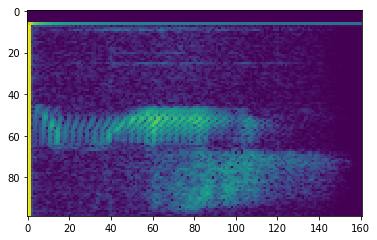

In [14]:
plt.imshow(df.iloc[1,0])

In [15]:
d = np.zeros((len(df),99,161))
c = 0
for i in df['Spectrogram'].values:
    i.reshape((1, 99,161))
    d[c,:,:]=i
    c =c +1

In [16]:
d[0].shape

(99, 161)

In [17]:
d.shape

(1500, 99, 161)

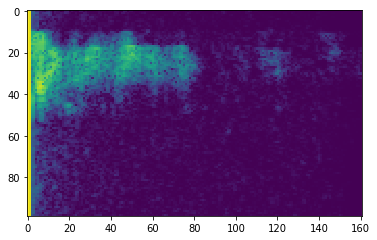

In [18]:
plt.imshow(d[500,:,:])

In [19]:
X = d
Y = df.word.values
print('Tamaño dataSet', X.shape)
print('\n')
Y = np.reshape(Y,(np.size(Y,0),1))
print('Y shape',Y.shape)
groups = df.speaker.values

Tamaño dataSet (1500, 99, 161)


Y shape (1500, 1)


In [20]:
def splitDataSet(X,Y,groups,test_size):              
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)
        gss.get_n_splits()
        returns = []
        for train_index, test_index in gss.split(X, Y, groups=groups):
            X_train_original, X_test_original = X[train_index], X[test_index]
            Y_train__original, Y_test_original = Y[train_index], Y[test_index]
            groups_original = groups[train_index]
            groups_test_original=groups[test_index]
            returns.append(X_train_original)
            returns.append(Y_train__original)
            returns.append(X_test_original)
            returns.append(Y_test_original)
            returns.append(groups_original)
            returns.append(groups_test_original) 
              
        return returns

In [21]:
data_train = splitDataSet(X,Y,groups,0.2)

In [22]:
X_train_original = data_train[0]
Y_train__original=data_train[1]
X_test_original=data_train[2]
Y_test_original=data_train[3]
groups_original=data_train[4]
groups_test_original=data_train[5]

In [23]:
X_train_original.shape

(1244, 99, 161)

In [24]:
Y_test_original.shape

(256, 1)

In [25]:
y_trainOHE = utils.to_categorical(Y_train__original)

In [26]:
y_trainOHE

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [27]:
num_classes = y_trainOHE.shape[1]

In [28]:
input_shape = X_train_original[0].shape
input_shape

(99, 161)

In [29]:
input_shape = (99, 161, 1)

In [30]:
X_train_original= np.expand_dims(X_train_original, axis=3)

In [31]:
X_train_original.shape

(1244, 99, 161, 1)

In [32]:
model = Sequential()

img= Input(shape=input_shape)

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

validity = model(img)

Model(img, validity)

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 157, 32)       832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 155, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 77, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 226688)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               29016192  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 29,036,165
Trainable params: 29,036,165
Non-trainable params: 0
________________________________________________________________

In [34]:
print("Training...")
history = model.fit(X_train_original, y_trainOHE, epochs=10, batch_size=10, validation_split=0.1, verbose=1)

Training...
Train on 1119 samples, validate on 125 samples
Instructions for updating:
Use tf.cast instead.


ResourceExhaustedError: OOM when allocating tensor of shape [226688,128] and type float
	 [[node training/Adam/zeros_4 (defined at <ipython-input-34-72712df7603e>:2) ]]

Caused by op 'training/Adam/zeros_4', defined at:
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-72712df7603e>", line 2, in <module>
    history = model.fit(X_train_original, y_trainOHE, epochs=10, batch_size=10, validation_split=0.1, verbose=1)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 880, in fit
    validation_steps=validation_steps)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 195, in model_iteration
    f = _make_execution_function(model, mode)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_arrays.py", line 122, in _make_execution_function
    return model._make_execution_function(mode)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1983, in _make_execution_function
    self._make_fit_function()
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1926, in _make_fit_function
    '_fit_function', [self.total_loss] + metrics_tensors)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1895, in _make_train_function_helper
    params=self._collected_trainable_weights, loss=self.total_loss)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/optimizers.py", line 500, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/optimizers.py", line 500, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py", line 1068, in zeros
    v = array_ops.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1817, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3367, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/julian/anaconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [226688,128] and type float
	 [[node training/Adam/zeros_4 (defined at <ipython-input-34-72712df7603e>:2) ]]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


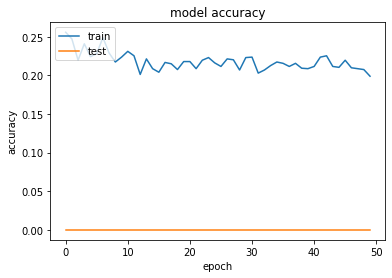

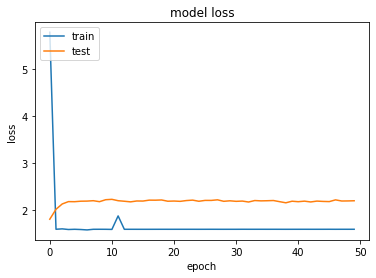

In [348]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict